# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data(training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data(training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn  # nn contains all of PyTorch's building block for neural net
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1'

## 1. Data (preparing and loading)

Data can be almost anything ... in machine learning.

* Excel Spreadsheet
* Images
* Videos
* Audio 
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representations.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [3]:
# Create *known* parameters

weight = 0.7
bias = 0.3

# Create
start = 0 
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in ML)

Let's createa a training and test set with our data.

In [5]:
# Create a train test split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test , y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, Visualize, Visualize!"

In [6]:
def plot_prediction(train_data=X_train,
                   train_labels=y_train,
                   test_data=X_test,
                   test_labels=y_test,
                   predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    
    plt.figure(figsize=(10,7))
    
    #plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')
    
    # Are there predictions?
    if predictions is not None:
        # Plot predictions if they exist
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
        
    # Show legend
    plt.legend(prop={"size": 14});

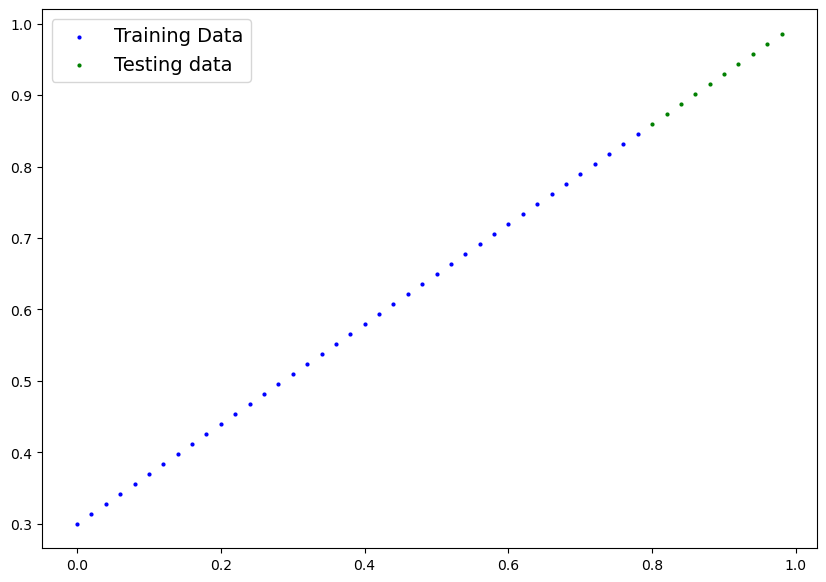

In [7]:
plot_prediction()

## 2. Build model

Our first PyTorch model!

What our model does:
* Start with random values (weight and bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values we used to create data)

How does it do so?

Through two main algorithms:
1. Gradient Descent
2. Backpropogation

In [8]:
from torch import nn
# Create a linear regression model class

class LinearRegressionModel(nn.Module):  # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                               requires_grad=True,  # can this parametere be updated via GD?
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,  # can this parametere be updated via GD?
                                            dtype=torch.float))
        
    # Forward method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor:  # 'x' is the input data
        return self.weights * x + self.bias  # this is the linear reg formula

### PyTorch model building essentials

* torch.nn - contains all of the building blocks for compuational graphs (a neural network)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural netowrk modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in forward method.

<img src="Workflow-1.png">

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside using `.parameters()`

In [9]:
# Create a random seed to get same random value
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
weight, bias      # These are our actual values and 
                  # what we got above are predicted ones, 
                  # so we gonna get close to actual

(0.7, 0.3)

> ***This is the whole premise of deep learning... start with random value
and bring them closer to actual values***

### Making prediction using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` on based on `X_test`

When we pass data through our model, it's going to run it through the `forward()` method.

In [12]:
y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [13]:
# Make predictions with model (BETTER APPROACH)

with torch.inference_mode():   # It disables useful thing available during training like gradient, it helps with faster speed
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [14]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

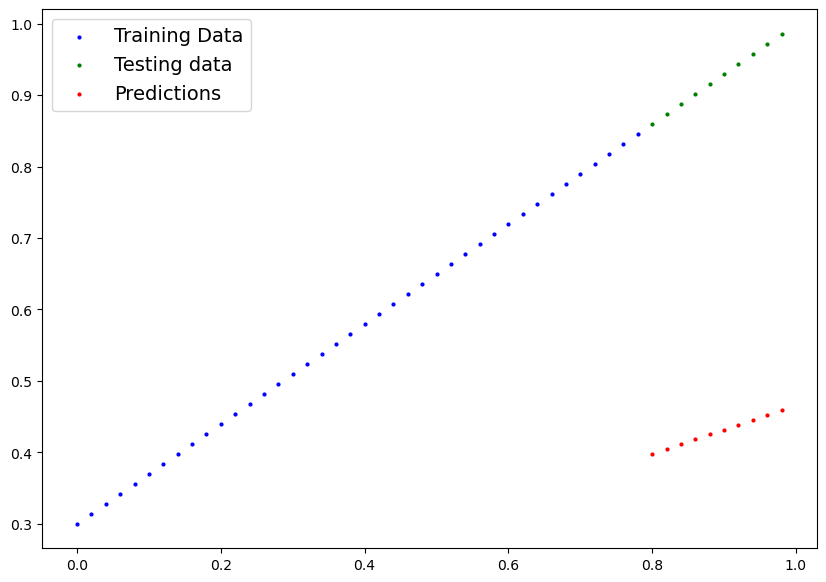

In [15]:
plot_prediction(predictions=y_preds)

## 3. Train Model

The whole idea of training is for a model to move from some *unknown* parameters to some *known* parameters (weight, bias).

OR in other words from a poor representation of data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss functions.

* Note: Loss function may also be called cost function or criterion

Things we need to train:

* **Loss Function:** A function to measure how wrong your model's predictions are to the ideal output, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the models parameteres (eg. weight, bias in our case) to improve the loss function.
    * Inside the optimizer you'll often have to set two parameters:
        * `params` - the model paramters you'd like to optimize, for example `params=model_0.parameters()`
        * `lr`(learning rate) - the learning rate is a hyperparameter that deines how small/big the optimizer changes the parameters with each step(a small `lr` results in small changes, vice versa)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

<img src="Workflow-2.png">

<img src="Workflow-3.png">

In [16]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Setup a loss function
loss_fn = nn.L1Loss()         # How wrong model is

# Setup an optimizer (Stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.01)   # learning rate =  possibly the most important learning hyperparameter you can set    

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data and do...
1. Forward Pass (this involves data moving through our model's `forward()` fn) to make predictions on data - also called forward propagation.
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss Backward - move backwards through network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer Step - Use the optimizer to adjust our model's parameters to try to adjust the loss (**gradient descent**)

<img src="Workflow-4.png">

In [18]:
torch.manual_seed(42)

# An epoch is one loop through the data... (Hyperparameter becoz we set it)
epochs = 200

# Track diffrent values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train()   # train mode in PyTorch sets all parameters that require gradients to require gradient
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()    # zeroing the grads (they accumulate by default)
    
    # 4. Perform back propagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()   # by default how to optimizer changes will accumulate through the loop so... we have to zero them above in step3 for the next iteration of the loop
    
    
    ### Testing
    model_0.eval()   # turns off different settings in model not needed for evaluation/testing  (dropout/bath norm layers)
    with torch.inference_mode():   # turns off gradient tracking & couple of more things
        # 1. Do the forward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    # Print Out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        # Print out model state_dict()
        print(model_0.state_dict())
    

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [19]:
import numpy as np
np.array(torch.tensor(loss_values).cpu().numpy())

array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

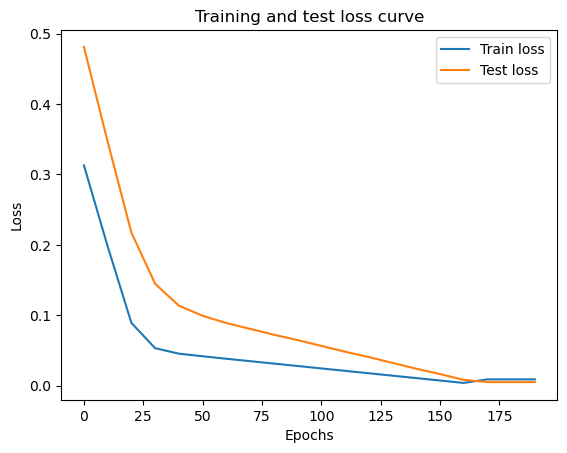

In [20]:
# Plot the loss curves

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

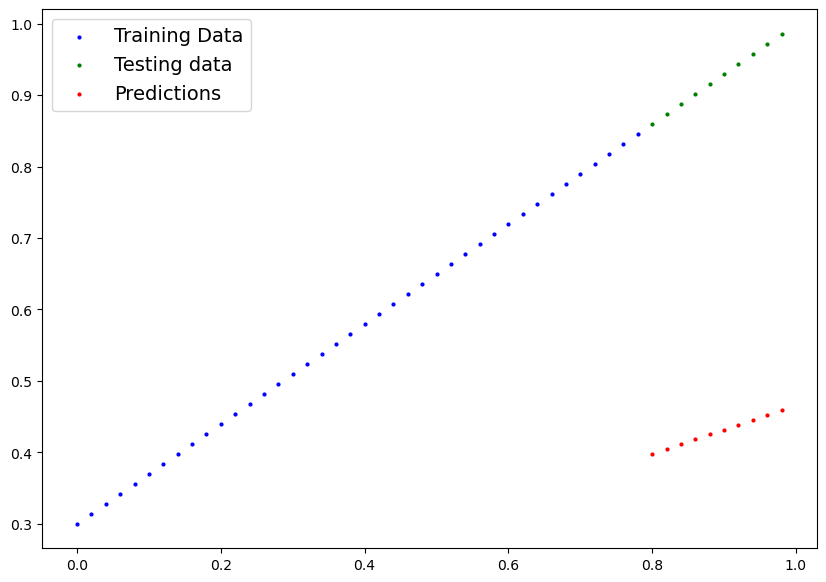

In [21]:
# Initial prediction
plot_prediction(predictions=y_preds)

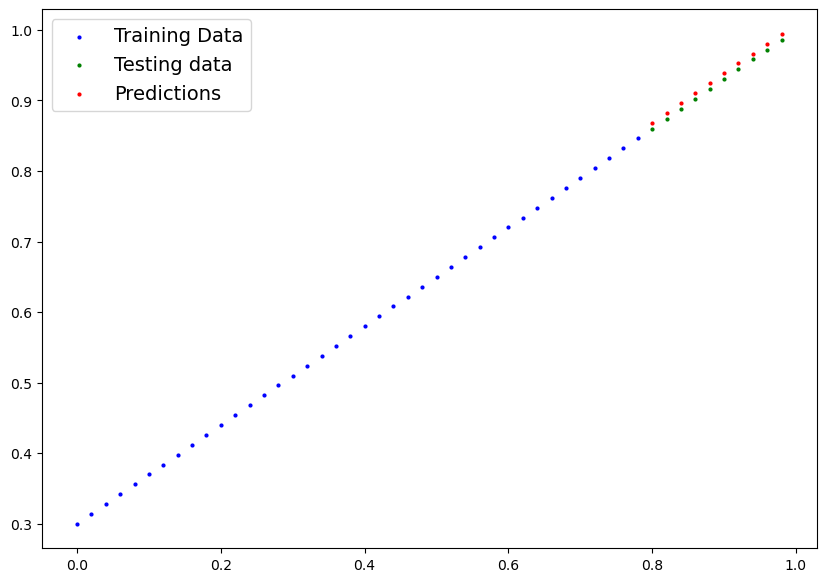

In [22]:
# New prediction

with torch.inference_mode():
    y_preds_new = model_0(X_test)

plot_prediction(predictions=y_preds_new);

In [23]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [24]:
weight, bias

(0.7, 0.3)

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` -  allows you to save a PyTorch object in Python's pickle format.
2. `torch.load()` -  allows you to load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict()` -  this allows to load a model's saved state dictionary.

In [25]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
          f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [26]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [27]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict() of model_0 (this will update the new instance  with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [28]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [29]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [30]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place.

In [31]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1'

**Create device-agnostic code.**

This means if we've got access to the GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [32]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

Using Device: cuda


### 6.1 Data

In [40]:
# Create some data using the linear regression formula of y= weight*X + bias

weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # errors will come without unsqueeze
y = weight*X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [41]:
# Split the data
train_split = int(0.8  * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

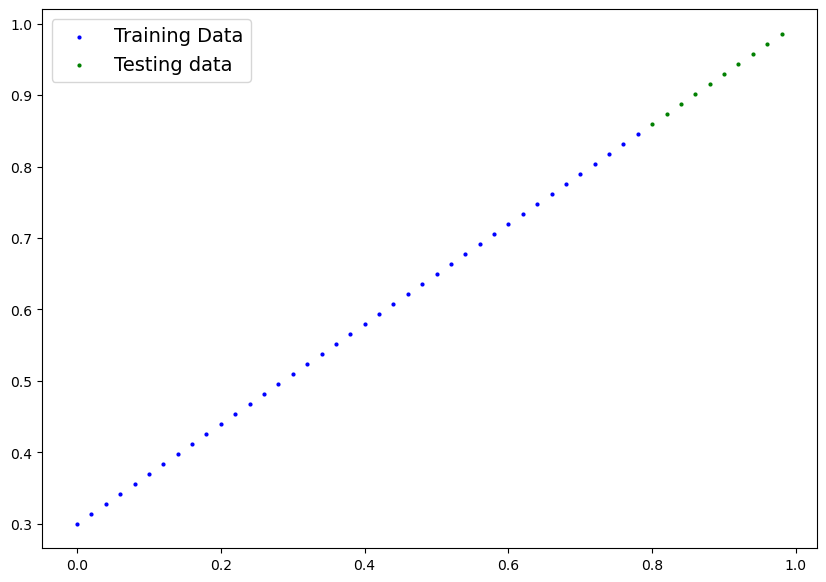

In [43]:
# Plot the data

plot_prediction(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch linear Model

In [44]:
# Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters / aka: linear transform, probing lyer,fc layer
        self.linear_layer = nn.Linear(in_features=1,
                                     out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.linear_layer(x)
    
# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [46]:
# Check the model current device

next(model_1.parameters()).device

device(type='cpu')

In [48]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss Function
* Optimizer
* Training Loop
* Testing Loop

In [50]:
# Setup the loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.01)

In [53]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (Device diagnostic code)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    # 1. Forward pass
    y_pred = model_1(X_train)
    
    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer Zero Grad
    optimizer.zero_grad()         # Optimizers accumulate gradients so we reset them
    
    # 4. Backpropagation
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        
        # Forward pass
        test_pred = model_1(X_test)
        
        # calculate loss
        test_loss = loss_fn(test_pred, y_test)
    
    # print out what's happenin'
    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416

In [54]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [55]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [60]:
# Turn model into evaluation mode

model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
    
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

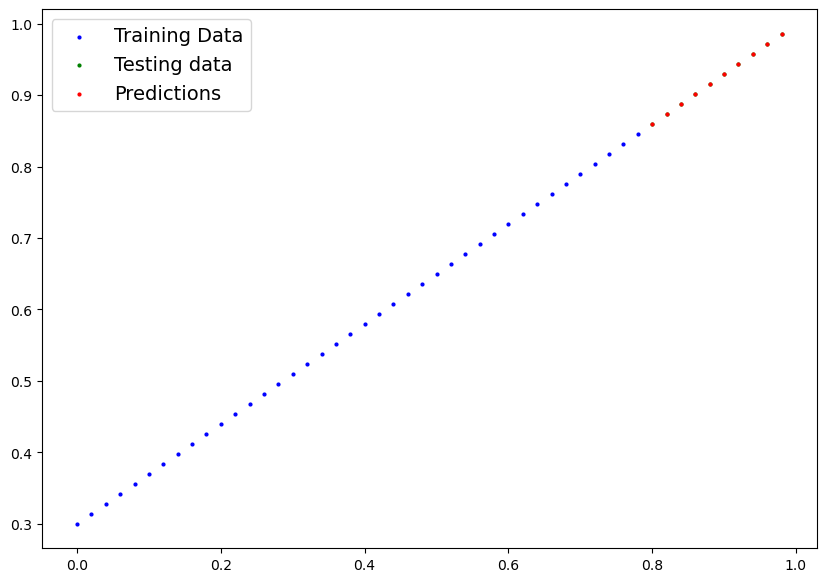

In [63]:
# Check out model prediction visually
plot_prediction(predictions=y_preds.cpu())

### 6.5 Saving and Loading a trained model

In [64]:
# Saving a model
from pathlib import Path

# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True, parents=True)

# Create Save model path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
          f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


In [65]:
# Load a PyTorch model

# Create new instance of linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [66]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [67]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [68]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
    
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Exercises & Extra-curriculum

Here's it - https://www.learnpytorch.io/01_pytorch_workflow/#exercises